In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
#dtInCU = 1000.0
#bigT = 100000
dtInCU = 2500.0
bigT = 40000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570464445  X= 20.0997201994404
A2=  -0.4996237064856289  X= 40.0
A2=  -0.5019378672755319  X= 16.740033480066963
A2=  -0.5018381151828868  X= 18.401316802633605
A2=  -0.5018730652697496  X= 15.347950695901392
A2=  -0.5019295973148135  X= 22.058364116728235
A2=  -0.5019295973148135  X= 22.058364116728235
MU= 0.3181619365115217 MASS= 0.09999012221832808


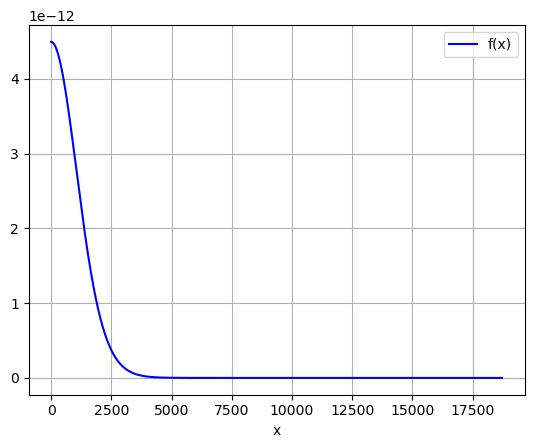

(1000,)


In [2]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

for index, value in enumerate(psi):
    if(value<1e-5):
        psi[index] = 0.0

psi = x*psi

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DX:", dx)
print("DT:", dt)

[0.00258441+0.j 0.00774838+0.j 0.01289782+0.j 0.01802312+0.j
 0.02311473+0.j 0.02816323+0.j 0.03315937+0.j 0.03809407+0.j
 0.04295847+0.j 0.04774396+0.j 0.0524422 +0.j 0.05704519+0.j
 0.06154521+0.j 0.06593493+0.j 0.07020739+0.j 0.07435603+0.j
 0.0783747 +0.j 0.08225769+0.j 0.08599975+0.j 0.08959605+0.j
 0.09304227+0.j 0.09633455+0.j 0.0994695 +0.j 0.10244422+0.j
 0.1052563 +0.j 0.10790382+0.j 0.1103853 +0.j 0.11269978+0.j
 0.11484671+0.j 0.11682604+0.j 0.11863814+0.j 0.1202838 +0.j
 0.12176422+0.j 0.12308102+0.j 0.12423618+0.j 0.12523202+0.j
 0.12607122+0.j 0.12675678+0.j 0.12729198+0.j 0.12768038+0.j
 0.12792578+0.j 0.12803222+0.j 0.12800395+0.j 0.12784538+0.j
 0.12756109+0.j 0.12715581+0.j 0.12663435+0.j 0.12600166+0.j
 0.12526271+0.j 0.12442258+0.j 0.12348633+0.j 0.12245906+0.j
 0.12134588+0.j 0.12015186+0.j 0.11888204+0.j 0.1175414 +0.j
 0.11613489+0.j 0.11466736+0.j 0.11314356+0.j 0.11156818+0.j
 0.10994577+0.j 0.10828078+0.j 0.10657755+0.j 0.10484026+0.j
 0.10307298+0.j 0.101279

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T
    for i in range(size):
        if i==0:
            T[i][i] = -3.0
            T[i][i+1] = 1.0
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0

    T = -1.0/2.0/dx/dx*T

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i]/x[i])*np.absolute(psi[i]/x[i])

def setupV2Grav():
    global V2Grav, phi

    rho = np.absolute(psi)*np.absolute(psi)/x/x
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+Q+V2Grav)

0 0.0 0.08351027137908527 0.05839835940165079
1 0.08351027137908527 0.08 0.05840128035384848
2 0.16351027137908528 0.08 0.058406089033238996
3 0.24351027137908526 0.08 0.05841277783385779
4 0.3235102713790853 0.08 0.05842133721300331
5 0.4035102713790853 0.08 0.058431754690571346
6 0.4835102713790853 0.08 0.058444014920712044
7 0.5635102713790853 0.08 0.05845810080264219
8 0.6435102713790852 0.08 0.0584739926044567
9 0.7235102713790852 0.08 0.05849166803443736
10 0.8035102713790852 0.08 0.058511103394701364
11 0.8835102713790851 0.08 0.05853227237102817
12 0.9635102713790851 0.08 0.05855514757835541
13 1.0435102713790851 0.08 0.05857969933670179
14 1.1235102713790852 0.08 0.05860589746189546
15 1.2035102713790853 0.08 0.05863371016304902
16 1.2835102713790854 0.08 0.05866310404023744
17 1.3635102713790854 0.08 0.058694045487221756
18 1.4435102713790855 0.08 0.05872649870233582
19 1.5235102713790856 0.08 0.05876043017664716
20 1.6035102713790856 0.08 0.058795802691439004
21 1.6835102713

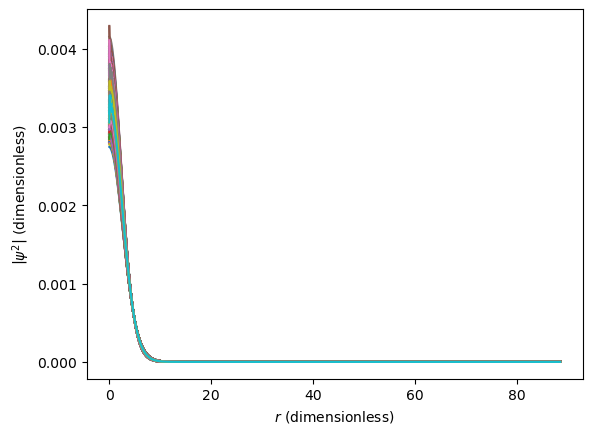

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

currentT = 0.0
hello = []
hello2 = []
ts = []
cfls = []
oldGM = GM
newGM = GM*1.2
for t in range(bigT):
    #Pertubation
    if(currentT<6.0):
        GM = newGM
    if(currentT>=6.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    print(t, currentT, dt, np.absolute(psi[0])/x[0])

    currentT = currentT + dt
    dt = min(0.08, 0.1*dx/abs((np.angle(psi[1])-np.angle(psi[0]))/(dx*Ra)/m/Ra/omegaA))

    if(GM == oldGM):
        def findMass():
            for i in range(size):
                if(i != 0):
                    temp = scipy.integrate.simpson(4.0*np.pi*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
                    if(temp > 0.99):
                        return i
            return size-1
        
        cfls.append((np.array(psi[1])-np.array(psi[0]))/(dx*Ra)/m/Ra/omegaA*dt/dx)
        hello2.append(findMass())
        hello.append(np.absolute(psi[0])*np.absolute(psi[0])/x[0]/x[0])
        ts.append(currentT)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

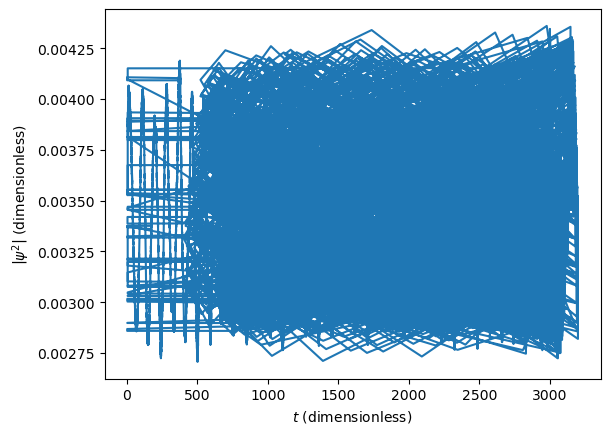

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

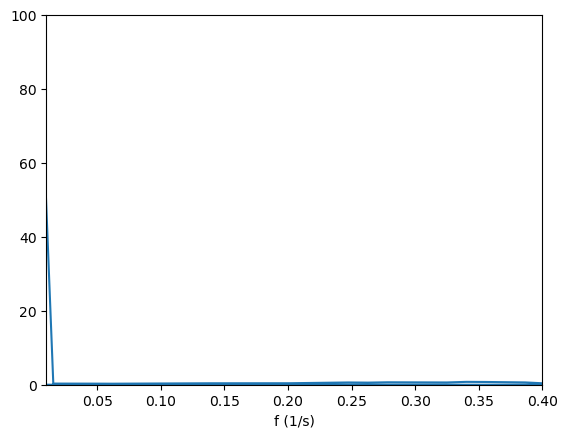

In [9]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100.0)
plt.xlabel("f (1/s)")

In [10]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.04 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.015464316335758038
0.030928632671516076 0.3140326283378972
0.13917884702182234 0.3928158430313253
0.1855717960290965 0.4098285699049653
0.2474290613721286 0.6097048858846443
0.2783576940436447 0.6590810854690345
0.34021495938667684 0.7729946417999994
0.43300085740122507 0.6481428722236939
0.4948581227442572 1.2350091916818786
0.5412510717515313 1.6883432438820976
0.5721797044230474 8.489535390016654
0.6340369697660796 1.096507208236003
0.6649656024375957 0.5647260734559013
0.6958942351091117 0.49380737480146847
0.7268228677806278 0.2362645523289973
0.819608765795176 0.23008757188552972
0.8814660311382081 0.18157791395107098
0.9742519291527565 1.4345854845895512
1.0361091944957885 0.23040905231511585
1.128895092510337 0.6459737976588011
1.175288041517611 0.11504495063181328
1.206216674189127 0.3495816893417539
1.252609623196401 0.14988503703485875
1.3299312048751915 0.24539158313373952
1.3917884702182235 0.25925477397424634
1.4691100518970135 0.38388866159343177
1.5155030009042878 0.1

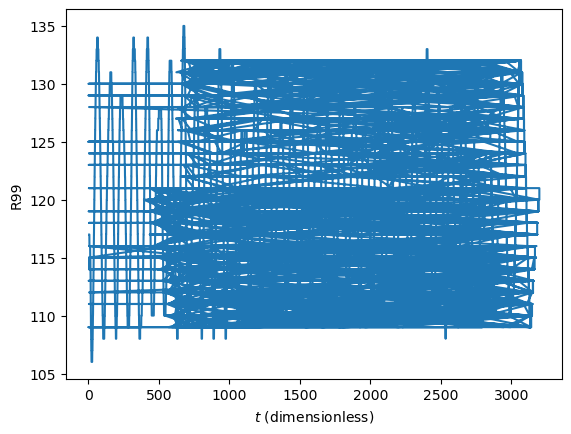

In [11]:
plt.plot(ts, hello2)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

Text(0.5, 0, 'f (1/s)')

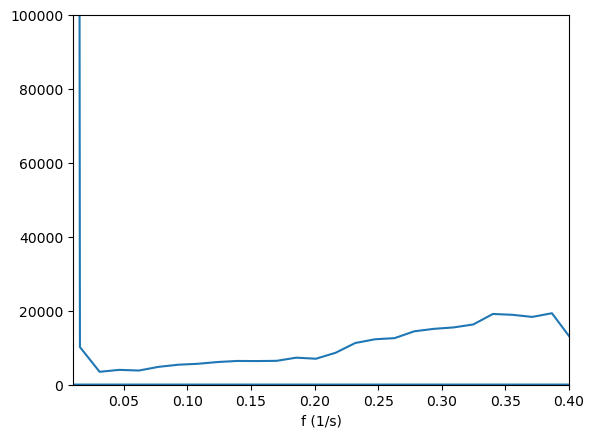

In [12]:
sp = np.fft.fft(hello2)
freq = np.fft.fftfreq(len(hello2), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [13]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 5000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.015464316335758038
0.13917884702182234 6431.0623755727665
0.1855717960290965 7319.884528342419
0.34021495938667684 19147.383662777072
0.386607908393951 19344.094965946133
0.43300085740122507 17217.864635077935
0.4639294900727412 18652.549757158893
0.4948581227442572 24131.465347468493
0.5412510717515313 34086.88759815497
0.5721797044230474 173535.32930669686
0.6340369697660796 15418.754005232537
0.6958942351091117 7287.01038877213
0.7577515004521439 5859.821027508962
0.804144449459418 5806.157094526404
0.9742519291527565 27650.968305766273
1.1443594088460949 17726.58809944223
1.206216674189127 8952.325556665877
1.3144668885394333 6535.997281545863
1.4691100518970135 5028.70698067409
1.546431633575804 5358.779480259348
1.65468184792611 6216.633752785062


[5.67510239e-02 5.61252838e-02 5.61352238e-02 5.60217720e-02
 5.60913201e-02 5.59678851e-02 5.58706452e-02 5.55801719e-02
 5.53190283e-02 5.49110687e-02 5.45713926e-02 5.41735266e-02
 5.38664917e-02 5.34658752e-02 5.30781716e-02 5.25623768e-02
 5.20997919e-02 5.15402643e-02 5.10215667e-02 5.04164953e-02
 4.98724451e-02 4.92475565e-02 4.86625977e-02 4.79747572e-02
 4.73327186e-02 4.65982189e-02 4.59270040e-02 4.51976049e-02
 4.45293223e-02 4.37770381e-02 4.30696089e-02 4.22749397e-02
 4.15320043e-02 4.07303515e-02 4.00020359e-02 3.92042987e-02
 3.84415375e-02 3.76128823e-02 3.68511943e-02 3.60336646e-02
 3.52749611e-02 3.44683275e-02 3.37178268e-02 3.29124972e-02
 3.21553760e-02 3.13513429e-02 3.05994813e-02 2.98065775e-02
 2.90747880e-02 2.83128967e-02 2.75997203e-02 2.68509569e-02
 2.61467197e-02 2.54147089e-02 2.47335388e-02 2.40244450e-02
 2.33612652e-02 2.26751170e-02 2.20291660e-02 2.13609173e-02
 2.07332432e-02 2.00911853e-02 1.94932413e-02 1.88857363e-02
 1.83181755e-02 1.774088

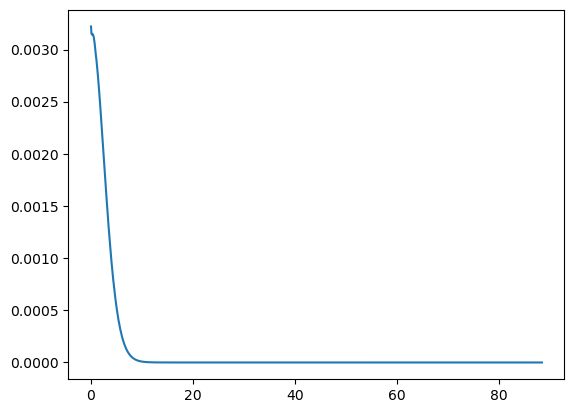

In [14]:
plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)
print(np.absolute(psi)/x)

/home/kklee/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kklee/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


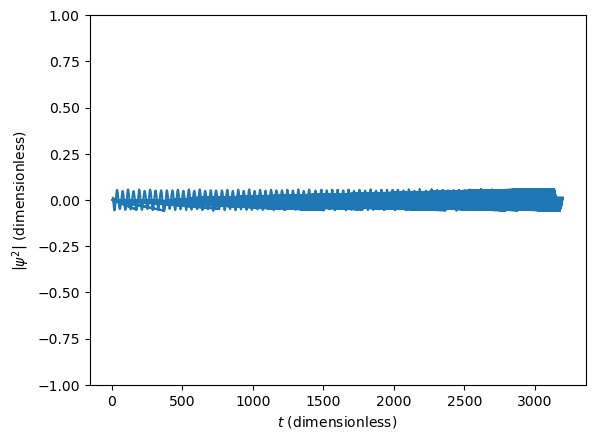

In [15]:
#plt.plot(ts, (np.array(hello4)-np.array(hello3))/(dx*Ra)/m/Ra/omegaA*dt/dx)
plt.plot(ts, cfls)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.ylim(-1.0,1.0)
plt.show()

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?